# Imports

In [2]:
import json
from unidecode import unidecode
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_recommenders as tfrs
from datetime import datetime
import plotly.express as px
import os
import matplotlib.pyplot as plt

from datetime import date

%matplotlib inline

## SEED

In [5]:
SEED = 42
tf.random.set_seed(SEED)

# Data

## Cleaner Functions

In [6]:
def name_2_month(data):
    d = {'enero': '1', 'febrero': '2', 'marzo': '3', 'abril': '4', 'mayo': '5', 'junio': '6', 'julio': '7', 'agosto': '8', 'septiembre': '9', 'octubre': '10', 'noviembre': '11', 'diciembre': '12'}
    data = data.map(d)
    return data

In [7]:
def fix_date(df: pd.DataFrame) -> pd.DataFrame:
    '''
    Serializa la fecha del dataframe

    Parameters
    ----------
    df : pd.DataFrame
    
    Returns
    -------
    pd.DataFrame

    '''
    date = df['FECHA'].str.split(' ', expand=True)
    month_day = date[1]
    month = date[3]
    month_number = name_2_month(month)
    year = date[5]
    df['FECHA'] = pd.to_datetime(year + '-' + month_number + '-' + month_day)

    return df

## Data Loaders

In [8]:
with open('standard_names.json','r') as f:
    standards_names = json.load(f)

standards_names = {key: unidecode(value) for key, value in standards_names.items()}

In [9]:
with open('products_description.json','r') as f:
    products_description = json.load(f)

products_description = {unidecode(key): unidecode(value) for key, value in products_description.items()}

In [10]:
df = pd.read_excel('Vtas Bar Septiembre 2022.xlsx')
df = fix_date(df)

## Data Viz

In [11]:
df.head()

,TIPO_DOC,NRO_DOC,FECHA,HORA,TOT_DOC,FOR_PAGO,NOMPROD,CANTIDAD,PRECIO,TOTAL,nomcc
0,BOLETA,120719,2022-09-02,23:01:10,59700,Tarjeta Crdto.,PISCOLON,1,5300,5300,BAR SOCIOS
1,BOLETA,120719,2022-09-02,23:01:10,59700,Tarjeta Crdto.,PISCOLON,1,5300,5300,BAR SOCIOS
2,BOLETA,120714,2022-09-02,00:00:03,6900,Tarjeta Crdto.,PISCOLON,1,5300,5300,BAR SOCIOS
3,BOLETA,120710,2022-09-02,21:56:55,81700,Tarjeta Crdto.,PISCOLON,1,5300,5300,BAR SOCIOS
4,BOLETA,120690,2022-09-02,18:56:56,42500,Tarjeta Crdto.,ABSOLUT SABORES,1,3900,3900,BAR SOCIOS


## Data Preprocessing

In [12]:
desc_df = pd.DataFrame.from_dict(products_description, orient='index', columns=['description'])
desc_df.reset_index(inplace=True)
desc_df.rename(columns={'index': 'product'}, inplace=True)


In [13]:
desc_df.head()

,product,description
0,Austral Calafate,
1,Agua Mineral Sin Gas,
2,Tom Collins,"Gin kantal, jugo de limon, jarabe de goma, soda"
3,Jugo Nectar Naranja,
4,Campari,


In [163]:
rec_df = pd.DataFrame()
rec_df['user_id'] = df['NRO_DOC']
rec_df['product'] = df['NOMPROD']
rec_df['quantity'] = df['CANTIDAD']
rec_df['date'] = pd.to_datetime(df['FECHA'].astype(str))
rec_df['hour'] = pd.to_datetime(df['HORA'].astype(str))

rec_df['product'] = rec_df['product'].map(standards_names)

rec_df = rec_df.groupby(by=['user_id','product','date','hour'], as_index=False)['quantity'].sum()

In [164]:
rec_df.head()

,user_id,product,date,hour,quantity
0,7359,Agua Mineral Sin Gas,2022-09-10,2022-12-01 13:53:49,1
1,7359,Arrollados Primavera / Jamon Queso,2022-09-10,2022-12-01 13:53:49,1
2,7359,Canada Dry,2022-09-10,2022-12-01 13:53:49,2
3,7359,Mojito,2022-09-10,2022-12-01 13:53:49,1
4,117186,Michelada,2022-09-01,2022-12-01 12:37:07,1


# Model

In [131]:
rec_df['user_id'] = rec_df['user_id'].astype('str')
rec_df['product'] = rec_df['product'].astype('str')

desc_df['product'] = desc_df['product'].astype('str')

In [132]:
rating_dataset = tf.data.Dataset.from_tensor_slices((
        tf.cast(rec_df['user_id'].values.reshape(-1,1), tf.string),
        tf.cast(rec_df['product'].values.reshape(-1,1), tf.string)
))

products_dataset = tf.data.Dataset.from_tensor_slices((tf.cast(desc_df['product'].values.reshape(-1,1), tf.string)))

In [133]:
@tf.function
def rename_ratings(x0,x1):
    y = {}
    y["user_id"] = x0
    y['product'] = x1
    return y

@tf.function
def rename_products(x0):
    y = {}
    y['product'] = x0
    return y

In [134]:
rating_dataset = rating_dataset.map(rename_ratings)
products_dataset = products_dataset.map(rename_products)

In [135]:
# Select the basic features.
rating_dataset = rating_dataset.map(lambda x: {
    "product": x["product"],
    "user_id": x["user_id"]
})

products_dataset = products_dataset.map(lambda x: x["product"])

In [136]:
DATASET_SIZE = rating_dataset.cardinality().numpy()

train_size = int(0.8 * DATASET_SIZE)
val_size = int(0.1 * DATASET_SIZE)
test_size = int(0.1 * DATASET_SIZE)

shuffled = rating_dataset.shuffle(DATASET_SIZE, seed=SEED, reshuffle_each_iteration=False)

train_dataset = shuffled.take(train_size)
test_dataset = shuffled.skip(train_size)
val_dataset = test_dataset.skip(test_size)
test_dataset = test_dataset.take(test_size)

In [137]:
unique_products = np.unique(np.concatenate(list(products_dataset)))
unique_user_ids = np.unique(np.concatenate(list(rating_dataset.map(lambda x: x['user_id']))))

In [154]:
embedding_dimension = 32

user_model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.StringLookup(
        vocabulary=unique_user_ids, mask_token=None),
        tf.keras.layers.Embedding(len(unique_user_ids) + 1,   
                                  embedding_dimension)
])
product_model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.StringLookup(
        vocabulary=unique_products, mask_token=None),
        tf.keras.layers.Embedding(len(unique_products) + 1, 
                                  embedding_dimension)
])

In [155]:
metrics = tfrs.metrics.FactorizedTopK(
  candidates=products_dataset.map(product_model)
)

task = tfrs.tasks.Retrieval(
  metrics=metrics
)

In [156]:
class RecomenderModel(tfrs.Model):

    def __init__(self, user_model: tf.keras.Model, product_model: tf.keras.Model, task: tfrs.tasks.Retrieval):
        super().__init__()

        #set up user and product representation
        self.user_model = user_model
        self.product_model = product_model

        #set up retrieval task
        self.task = task
    
    def compute_loss(self, features, training=False) -> tf.Tensor:
        #Define how the loss is computed

        user_embeddings = self.user_model(features["user_id"])
        product_embeddings = self.product_model(features["product"])

        return self.task(user_embeddings,product_embeddings)

In [157]:
cache_train_dataset= train_dataset.cache()
cache_val_dataset = val_dataset.cache()
cache_test_dataset = test_dataset.cache()

In [158]:
# Tensorboard 
time_now = datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = "logs/scalars/" + time_now


checkpoint_path = f"model_{time_now}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

my_callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir=logdir),
    tf.keras.callbacks.EarlyStopping(patience=5, monitor="val_loss", restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=False,verbose=1, save_best_only=True)
]

In [160]:
# Create a retrieval model.
learning_rate = 0.001

model = RecomenderModel(user_model, product_model, task)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

In [ ]:
# Train
history = model.fit(train_dataset, epochs=30, verbose=1, callbacks=my_callbacks, validation_data=val_dataset)

In [302]:
# Use brute-force search to set up retrieval using the trained representations.
index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
index.index_from_dataset(products_dataset.map(lambda product: (product, model.product_model(product))))

In [276]:
user = "42"

# Get some recommendations.
_, titles = index(np.array([user]))
print(f"Top 3 recommendations for user {user}: {titles[0, :3]}")

Top 3 recommendations for user 42: [b'Gin Kantal' b'Ballantines' b'Tabla Americana']


In [297]:
preds_metrics = model.evaluate(cache_test_dataset, return_dict=True)

269/269 [==============================] - 21s 80ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0037 - factorized_top_k/top_5_categorical_accuracy: 0.0483 - factorized_top_k/top_10_categorical_accuracy: 0.0967 - factorized_top_k/top_50_categorical_accuracy: 0.5799 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 0.0000e+00 - regularization_loss: 0.0000e+00 - total_loss: 0.0000e+00


In [314]:
date = datetime.now().strftime("%Y%m%d-%H%M%S")
model_name = f"trained_model_{date}"
path = os.path.join(os.getcwd(),model_name)

In [ ]:
# Save the model
tf.saved_model.save(index, path+'_acurate')

In [ ]:
#Load Model

# Load it back; can also be done in TensorFlow Serving.
loaded = tf.saved_model.load(path)

  # Pass a user id in, get top predicted movie titles back.
scores, titles = loaded(["42"])

print(f"Recommendations: {titles[0][:3]}")

In [266]:
accuracy = history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]
print(f"Top-100 accuracy: {accuracy:.2f}.")

Top-100 accuracy: 1.00.


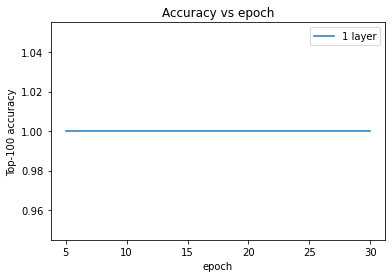

In [269]:
num_validation_runs = len(history.history["val_factorized_top_k/top_100_categorical_accuracy"])
epochs = [(x + 1)* 5 for x in range(num_validation_runs)]

plt.plot(epochs, history.history["val_factorized_top_k/top_100_categorical_accuracy"], label="1 layer")
plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("Top-100 accuracy")
plt.legend()

In [259]:
losses = pd.DataFrame()
losses['val_loss'] = history.history['factorized_top_k/top_1_categorical_accuracy']
losses['loss'] = history.history['loss']

In [260]:
fig = px.line(losses[['loss','val_loss']], title='Mean Squared Error')
fig.update_xaxes(title_text='Epoch')
fig.update_yaxes(title_text='MSE')

fig.update_layout(
    autosize=False,
    width=800,
    height=800,)

fig.show()